In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from torchvision.datasets import ImageFolder
import os
from torchvision.transforms import v2

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
num_of_patches = 576
num_classes = 5

weights_path = "models/best_model_ckpt.pth"   # Path to pretrined weights
dataset_path = "dataset"

In [4]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

# Load a pre-trained ViT model and feature extractor
model_name = 'google/vit-large-patch16-384'
model = ViTForImageClassification.from_pretrained(
    model_name, 
    attn_implementation='eager'
)
model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)
model.to(device)

model.load_state_dict(torch.load(weights_path, weights_only=True, map_location=device))

<All keys matched successfully>

In [5]:
# Dataset preparation
transform = v2.Compose([
    v2.Resize((384, 384)),
    v2.ToTensor(),
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_ds = ImageFolder(os.path.join(dataset_path, "train/multiclass"), transform=transform)

/users/scratch1/s189737/attention/vit/venv/lib64/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [6]:
# Read image
image, target = train_ds[-4]

image = image.to(device)
outputs = model(image.unsqueeze(0), output_attentions=True)

print(f"Prediction: {outputs.logits.argmax()}, Target: {target}")

# Getting the attentions
attentions = outputs.attentions 

Prediction: 4, Target: 4


In [7]:
attentions[0].shape

torch.Size([1, 16, 577, 577])

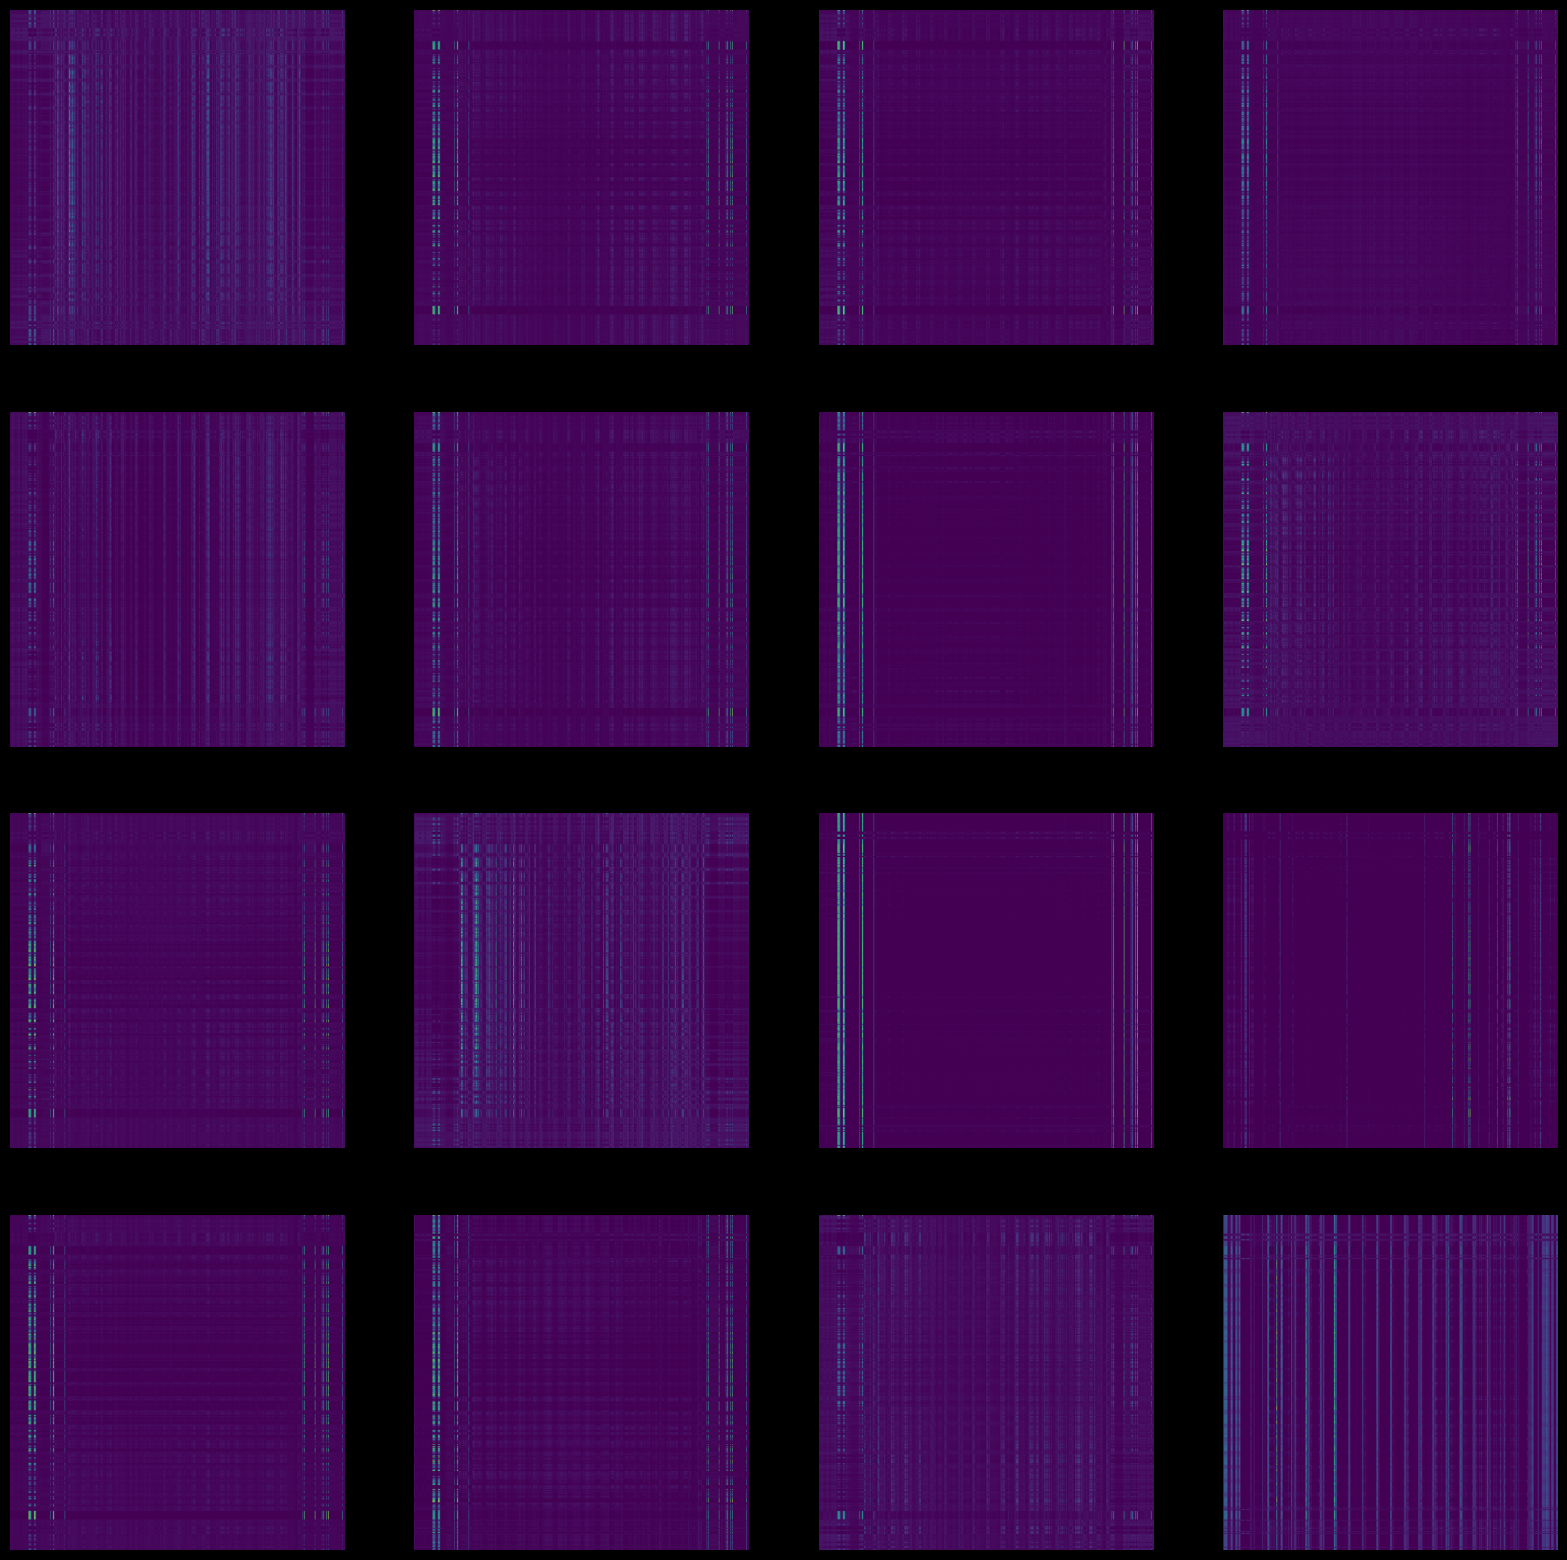

In [8]:
ig, axs = plt.subplots(4, 4, figsize=(20, 20))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(attentions[-1][0, i, :, :].detach().cpu().numpy())
    ax.axis('off')

In [9]:
def attention_rollout(attentions):
    # Initialize rollout with identity matrix
    rollout = torch.eye(attentions[0].size(-1)).to(attentions[0].device)

    # Multiply attention maps layer by layer
    for attention in attentions:
        attention_heads_fused = attention.mean(dim=1) # Average attention across heads
        attention_heads_fused += torch.eye(attention_heads_fused.size(-1)).to(attention_heads_fused.device) # A + I
        attention_heads_fused /= attention_heads_fused.sum(dim=-1, keepdim=True) # Normalizing A
        rollout = torch.matmul(rollout, attention_heads_fused) # Multiplication

    return rollout

In [10]:
rollout = attention_rollout(attentions)

In [11]:
rollout.shape

torch.Size([1, 577, 577])

In [12]:
cls_attention = rollout[0, 1:, 0]  # Get attention values from [CLS] token to all patches
cls_attention = cls_attention.reshape(int(np.sqrt(num_of_patches)), int(np.sqrt(num_of_patches)))

In [13]:
# Normalize the attention map for better visualization
cls_attention = (cls_attention - cls_attention.min()) / (cls_attention.max() - cls_attention.min())
cls_attention = cls_attention.cpu().detach().numpy()
cls_attention = (cls_attention + 1) / 2

In [14]:
# Convert image from pytorch tensor to numpy array
image = (image.permute(1, 2, 0).cpu().numpy() + 1)/2


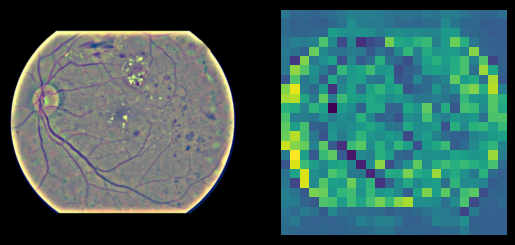

In [15]:
fig, axs = plt.subplots(1, 2)
ax = axs[0]
ax.axis('off')
ax.imshow(image)

ax = axs[1]
ax.axis('off')
ax.imshow(cls_attention)


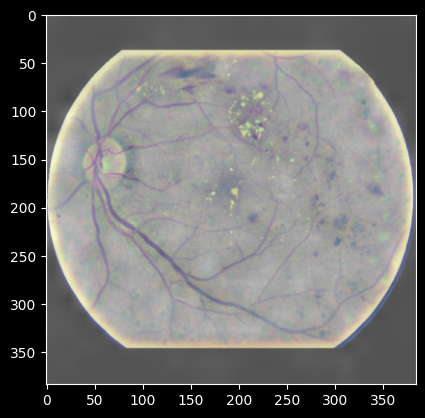

In [16]:
cls_attention_resized = cv2.resize(cls_attention, (image.shape[1], image.shape[0]))
cls_attention_resized_rgb = cv2.cvtColor(cls_attention_resized, cv2.COLOR_GRAY2BGR)
plt.imshow(cv2.addWeighted(image, 0.5, cls_attention_resized_rgb, 0.5, 0))